<a href="https://colab.research.google.com/github/YASSIRAMRAOUI/Text-Mining/blob/main/Atelier_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Atelier 4 : Clustering et Détection de Plagiat**

# **📦 1. Préparation de l'environnement et chargement des données**

In [1]:
# Installation des librairies nécessaires
!pip install gdown scikit-learn pandas numpy matplotlib seaborn nltk

# Importation des bibliothèques
import pandas as pd
import numpy as np
import glob
from glob import glob
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, OPTICS
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

# Téléchargement des ressources NLTK
nltk.download('all', quiet=True)

print("✅ Environnement prêt!")

✅ Environnement prêt!


In [2]:
# Téléchargement du dataset
!gdown --id 1j1OSM0LTJEj6VAfed7-UUQTGoiVMJ2If -O corpus.zip
!unzip -q corpus.zip -d /content/

print("✅ Dataset téléchargé et extrait!")

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1j1OSM0LTJEj6VAfed7-UUQTGoiVMJ2If
To: /content/corpus.zip
100% 76.7k/76.7k [00:00<00:00, 14.1MB/s]
✅ Dataset téléchargé et extrait!


In [3]:
# Chargement des données dans des DataFrames
d1 = {'tasks': [], 'groups': [], 'persons': [], 'resp': [], 'filename': []}
files = glob("/content/corpus-20090418/g*task*.txt")

for file in sorted(files):
    f = open(file, "r", errors="ignore")
    task = file[len(file.split(".")[0])-1]
    d1["tasks"].append(task)
    group = file[len(file.split(".")[0])-9]
    d1["groups"].append(group)
    user = file[len(file.split(".")[0])-7]
    d1["persons"].append(user)
    resp = f.read()
    d1["resp"].append(resp)
    d1["filename"].append(file.split('/')[-1])

d2 = {'tasks': [], 'resp': [], 'filename': []}
files = glob("/content/corpus-20090418/orig*.txt")

for file in sorted(files):
    f = open(file, "r", errors="ignore")
    task = file[len(file.split(".")[0])-1]
    d2["tasks"].append(task)
    resp = f.read()
    d2["resp"].append(resp)
    d2["filename"].append(file.split('/')[-1])

tasks_pers = pd.DataFrame(data=d1)
tasks_orig = pd.DataFrame(data=d2)

print("📊 Statistiques du corpus:")
print(f"Nombre de réponses d'étudiants: {len(tasks_pers)}")
print(f"Nombre de réponses originales: {len(tasks_orig)}")
print(f"\nTâches disponibles: {sorted(tasks_pers['tasks'].unique())}")
print(f"Groupes: {sorted(tasks_pers['groups'].unique())}")
print(f"Personnes par groupe: {sorted(tasks_pers['persons'].unique())}")

print("\n📄 Aperçu des données:")
print(tasks_pers.head())

📊 Statistiques du corpus:
Nombre de réponses d'étudiants: 95
Nombre de réponses originales: 5

Tâches disponibles: ['a', 'b', 'c', 'd', 'e']
Groupes: ['0', '1', '2', '3', '4']
Personnes par groupe: ['A', 'B', 'C', 'D', 'E']

📄 Aperçu des données:
  tasks groups persons                                               resp  \
0     a      0       A  Inheritance is a basic concept of Object-Orien...   
1     b      0       A  PageRank is a link analysis algorithm used by ...   
2     c      0       A  The vector space model (also called, term vect...   
3     d      0       A  Bayes’ theorem was names after Rev Thomas Baye...   
4     e      0       A  Dynamic Programming is an algorithm design tec...   

         filename  
0  g0pA_taska.txt  
1  g0pA_taskb.txt  
2  g0pA_taskc.txt  
3  g0pA_taskd.txt  
4  g0pA_taske.txt  


# **🔧 2. Prétraitement et Vectorisation TF-IDF**

In [4]:
def preprocess_text(text):
    """Prétraitement du texte: tokenization, lemmatization, suppression des stopwords"""
    # Tokenization
    tokens = word_tokenize(text.lower())

    # Initialisation du lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Stopwords anglais
    stop_words = set(stopwords.words('english'))

    # Lemmatization et filtrage
    tokens = [lemmatizer.lemmatize(token) for token in tokens
              if token.isalnum() and token not in stop_words and len(token) > 2]

    return ' '.join(tokens)

def tfidf_vectorization():
    """Vectorisation TF-IDF du corpus complet"""
    # Concaténation de tous les documents
    corpus = pd.concat([tasks_pers["resp"], tasks_orig["resp"]], ignore_index=True)

    # Prétraitement
    print("⏳ Prétraitement des documents...")
    corpus_preprocessed = [preprocess_text(doc) for doc in corpus]

    # Vectorisation TF-IDF
    print("⏳ Vectorisation TF-IDF...")
    vectorizer = TfidfVectorizer(max_features=1000, min_df=2, max_df=0.8)
    vectors = vectorizer.fit_transform(corpus_preprocessed)

    print(f"✅ Vectorisation terminée: {vectors.shape[0]} documents, {vectors.shape[1]} features")

    return vectors, vectorizer, corpus_preprocessed

# Exécution de la vectorisation
vectors, vectorizer, corpus_preprocessed = tfidf_vectorization()

⏳ Prétraitement des documents...
⏳ Vectorisation TF-IDF...
✅ Vectorisation terminée: 100 documents, 898 features


# **📊 3. Clustering avec K-Means**

In [5]:
# Réduction de dimensionnalité avec PCA pour visualisation
print("⏳ Réduction de dimensionnalité avec PCA...")
pca = PCA(n_components=2, random_state=42)
vectors_2d = pca.fit_transform(vectors.toarray())

# Application de K-Means avec 5 clusters (une pour chaque tâche originale)
print("\n⏳ Application de K-Means...")
km = KMeans(n_clusters=5, init='k-means++', n_init=20, max_iter=300, random_state=42)
km.fit(vectors_2d)
y_kmeans = km.predict(vectors_2d)

# Calcul des métriques de qualité
silhouette = silhouette_score(vectors_2d, y_kmeans)
calinski = calinski_harabasz_score(vectors_2d, y_kmeans)
davies_bouldin = davies_bouldin_score(vectors_2d, y_kmeans)

print(f"\n📈 Métriques de qualité du clustering K-Means:")
print(f"  - Silhouette Score: {silhouette:.4f} (plus proche de 1 = meilleur)")
print(f"  - Calinski-Harabasz Score: {calinski:.4f} (plus élevé = meilleur)")
print(f"  - Davies-Bouldin Score: {davies_bouldin:.4f} (plus bas = meilleur)")
print(f"  - Inertie (score): {km.score(vectors_2d):.4f}")

⏳ Réduction de dimensionnalité avec PCA...

⏳ Application de K-Means...

📈 Métriques de qualité du clustering K-Means:
  - Silhouette Score: 0.7459 (plus proche de 1 = meilleur)
  - Calinski-Harabasz Score: 664.4379 (plus élevé = meilleur)
  - Davies-Bouldin Score: 0.3298 (plus bas = meilleur)
  - Inertie (score): -0.7082


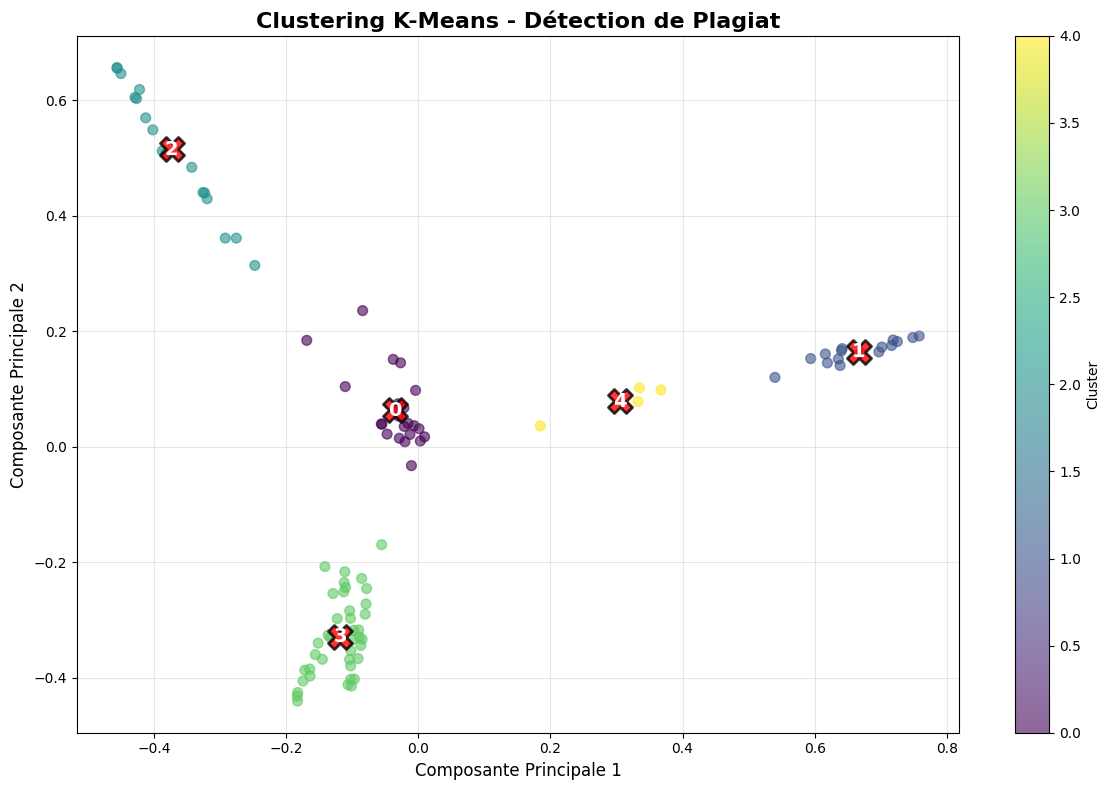


🎯 Attribution des clusters: [3 0 1 2 3 3 0 1 2 3 3 0 1 2 3 3 0 1 0 3 3 0 1 0 3 3 0 1 2 3 3 0 1 2 3 3 0
 1 2 3 3 0 1 2 3 3 0 1 2 3 3 0 1 2 3 3 0 4 2 3 3 0 1 2 3 3 0 1 2 3 3 0 4 2
 3 3 0 1 2 3 3 0 4 2 3 3 0 4 2 3 3 0 1 0 3 3 0 1 2 3]


In [6]:
# Visualisation des clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c=y_kmeans, s=50, cmap='viridis', alpha=0.6)
centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=300, alpha=0.8, marker='X', edgecolors='black', linewidth=2)

# Numéroter chaque centroïde
for i, (x, y) in enumerate(centers):
    plt.text(x, y, str(i), fontsize=14, ha='center', va='center',
             color='white', weight='bold')

plt.title('Clustering K-Means - Détection de Plagiat', fontsize=16, fontweight='bold')
plt.xlabel('Composante Principale 1', fontsize=12)
plt.ylabel('Composante Principale 2', fontsize=12)
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n🎯 Attribution des clusters: {y_kmeans}")

# **🔍 4. Exercice 1: Analyse des clusters et calcul de similarité**

In [7]:
# Organisation des documents par cluster
clusters_dict = {}
for i in range(5):
    cluster_indices = [idx for idx, x in enumerate(y_kmeans) if x == i]
    clusters_dict[f'Cluster_{i}'] = cluster_indices

# Affichage détaillé des clusters
print("=" * 80)
print("📋 COMPOSITION DES CLUSTERS")
print("=" * 80)

total_docs = len(tasks_pers) + len(tasks_orig)
num_student_docs = len(tasks_pers)

for cluster_name, indices in clusters_dict.items():
    print(f"\n{cluster_name}: {len(indices)} documents")
    print("-" * 80)

    # Séparer les documents originaux et étudiants
    original_docs = [i for i in indices if i >= num_student_docs]
    student_docs = [i for i in indices if i < num_student_docs]

    if original_docs:
        print(f"  📄 Documents originaux: {len(original_docs)}")
        for idx in original_docs:
            orig_idx = idx - num_student_docs
            print(f"     → Task {tasks_orig.iloc[orig_idx]['tasks']}: {tasks_orig.iloc[orig_idx]['filename']}")

    if student_docs:
        print(f"  👥 Documents étudiants: {len(student_docs)}")
        # Grouper par tâche
        tasks_in_cluster = {}
        for idx in student_docs:
            task = tasks_pers.iloc[idx]['tasks']
            if task not in tasks_in_cluster:
                tasks_in_cluster[task] = []
            tasks_in_cluster[task].append(idx)

        for task, doc_indices in sorted(tasks_in_cluster.items()):
            print(f"     → Task {task}: {len(doc_indices)} documents")
            for idx in doc_indices[:5]:  # Montrer les 5 premiers
                row = tasks_pers.iloc[idx]
                print(f"        • Group {row['groups']}, Person {row['persons']}: {row['filename']}")

📋 COMPOSITION DES CLUSTERS

Cluster_0: 23 documents
--------------------------------------------------------------------------------
  📄 Documents originaux: 1
     → Task b: orig_taskb.txt
  👥 Documents étudiants: 22
     → Task b: 19 documents
        • Group 0, Person A: g0pA_taskb.txt
        • Group 0, Person B: g0pB_taskb.txt
        • Group 0, Person C: g0pC_taskb.txt
        • Group 0, Person D: g0pD_taskb.txt
        • Group 0, Person E: g0pE_taskb.txt
     → Task d: 3 documents
        • Group 0, Person D: g0pD_taskd.txt
        • Group 0, Person E: g0pE_taskd.txt
        • Group 4, Person E: g4pE_taskd.txt

Cluster_1: 16 documents
--------------------------------------------------------------------------------
  📄 Documents originaux: 1
     → Task c: orig_taskc.txt
  👥 Documents étudiants: 15
     → Task c: 15 documents
        • Group 0, Person A: g0pA_taskc.txt
        • Group 0, Person B: g0pB_taskc.txt
        • Group 0, Person C: g0pC_taskc.txt
        • Group 0, Perso

In [8]:
# Calcul de la similarité cosinus entre tous les documents
print("\n" + "=" * 80)
print("📐 CALCUL DE SIMILARITÉ COSINUS")
print("=" * 80)

# Calcul de la matrice de similarité
similarity_matrix = cosine_similarity(vectors)

def classify_plagiarism(similarity_score):
    """Classifie le type de plagiat selon le score de similarité"""
    if similarity_score >= 0.70:
        return "Cut (70-100%)"
    elif similarity_score >= 0.40:
        return "Heavy (40-70%)"
    elif similarity_score >= 0.10:
        return "Light (10-40%)"
    else:
        return "Non (<10%)"

# Analyse de la similarité pour chaque cluster
for cluster_name, indices in clusters_dict.items():
    print(f"\n{cluster_name}:")
    print("-" * 80)

    # Trouver le document original dans ce cluster
    num_student_docs = len(tasks_pers)
    original_docs = [i for i in indices if i >= num_student_docs]
    student_docs = [i for i in indices if i < num_student_docs]

    if original_docs and student_docs:
        orig_idx = original_docs[0]
        orig_task_idx = orig_idx - num_student_docs
        original_task = tasks_orig.iloc[orig_task_idx]['tasks']

        print(f"📄 Document original: Task {original_task}")
        print(f"👥 Analyse de {len(student_docs)} documents étudiants:\n")

        # Calculer la similarité de chaque document étudiant avec l'original
        similarities = []
        for student_idx in student_docs[:10]:  # Limiter à 10 pour l'affichage
            sim_score = similarity_matrix[orig_idx][student_idx]
            student_info = tasks_pers.iloc[student_idx]
            plagiarism_type = classify_plagiarism(sim_score)

            similarities.append({
                'filename': student_info['filename'],
                'group': student_info['groups'],
                'person': student_info['persons'],
                'similarity': sim_score,
                'type': plagiarism_type
            })

        # Trier par similarité décroissante
        similarities.sort(key=lambda x: x['similarity'], reverse=True)

        # Afficher les résultats
        for sim in similarities:
            print(f"  {sim['filename']:<30} | Sim: {sim['similarity']:.3f} | Type: {sim['type']}")

        # Statistiques
        if similarities:
            avg_sim = np.mean([s['similarity'] for s in similarities])
            print(f"\n  📊 Similarité moyenne: {avg_sim:.3f}")

    elif not original_docs:
        print("  ⚠️ Aucun document original dans ce cluster")
        print(f"  👥 {len(student_docs)} documents étudiants sans référence originale")


📐 CALCUL DE SIMILARITÉ COSINUS

Cluster_0:
--------------------------------------------------------------------------------
📄 Document original: Task b
👥 Analyse de 22 documents étudiants:

  g0pA_taskb.txt                 | Sim: 0.756 | Type: Cut (70-100%)
  g1pA_taskb.txt                 | Sim: 0.590 | Type: Heavy (40-70%)
  g0pB_taskb.txt                 | Sim: 0.550 | Type: Heavy (40-70%)
  g1pB_taskb.txt                 | Sim: 0.525 | Type: Heavy (40-70%)
  g0pE_taskb.txt                 | Sim: 0.495 | Type: Heavy (40-70%)
  g1pD_taskb.txt                 | Sim: 0.473 | Type: Heavy (40-70%)
  g0pC_taskb.txt                 | Sim: 0.464 | Type: Heavy (40-70%)
  g0pD_taskb.txt                 | Sim: 0.407 | Type: Heavy (40-70%)
  g0pD_taskd.txt                 | Sim: 0.030 | Type: Non (<10%)
  g0pE_taskd.txt                 | Sim: 0.023 | Type: Non (<10%)

  📊 Similarité moyenne: 0.431

Cluster_1:
--------------------------------------------------------------------------------
📄 Do

# **🎯 5. Exercice 2: Comparaison de différents algorithmes de clustering**

## **5.1. Méthodes de vectorisation alternatives**

In [9]:
def get_vectorizations():
    """Calcule différentes représentations vectorielles du corpus"""
    corpus = pd.concat([tasks_pers["resp"], tasks_orig["resp"]], ignore_index=True)
    corpus_preprocessed = [preprocess_text(doc) for doc in corpus]

    vectorizations = {}

    # 1. One-Hot Vector (OHV)
    print("⏳ Vectorisation OHV...")
    ohv_vectorizer = CountVectorizer(binary=True, max_features=1000)
    vectorizations['OHV'] = ohv_vectorizer.fit_transform(corpus_preprocessed)

    # 2. Bag of Words (BOW)
    print("⏳ Vectorisation BOW...")
    bow_vectorizer = CountVectorizer(max_features=1000)
    vectorizations['BOW'] = bow_vectorizer.fit_transform(corpus_preprocessed)

    # 3. TF-IDF (déjà calculé mais on le refait pour cohérence)
    print("⏳ Vectorisation TF-IDF...")
    tfidf_vectorizer = TfidfVectorizer(max_features=1000, min_df=2, max_df=0.8)
    vectorizations['TFIDF'] = tfidf_vectorizer.fit_transform(corpus_preprocessed)

    # 4. Word2Vec (moyenne des embeddings de mots)
    try:
        from gensim.models import Word2Vec
        print("⏳ Vectorisation Word2Vec...")

        tokenized_docs = [doc.split() for doc in corpus_preprocessed]
        w2v_model = Word2Vec(sentences=tokenized_docs, vector_size=100, window=5, min_count=2, workers=4)

        def doc_to_vec(doc):
            words = [w for w in doc.split() if w in w2v_model.wv.index_to_key]
            if len(words) > 0:
                return np.mean(w2v_model.wv[words], axis=0)
            else:
                return np.zeros(100)

        w2v_vectors = np.array([doc_to_vec(doc) for doc in corpus_preprocessed])
        from scipy.sparse import csr_matrix
        vectorizations['Word2Vec'] = csr_matrix(w2v_vectors)
    except Exception as e:
        print(f"⚠️ Word2Vec non disponible: {e}")

    # 5. Doc2Vec
    try:
        from gensim.models.doc2vec import Doc2Vec, TaggedDocument
        print("⏳ Vectorisation Doc2Vec...")

        tagged_docs = [TaggedDocument(words=doc.split(), tags=[str(i)])
                       for i, doc in enumerate(corpus_preprocessed)]
        d2v_model = Doc2Vec(tagged_docs, vector_size=100, window=5, min_count=2, workers=4, epochs=20)

        d2v_vectors = np.array([d2v_model.infer_vector(doc.split()) for doc in corpus_preprocessed])
        vectorizations['Doc2Vec'] = csr_matrix(d2v_vectors)
    except Exception as e:
        print(f"⚠️ Doc2Vec non disponible: {e}")

    print(f"✅ {len(vectorizations)} méthodes de vectorisation calculées")
    return vectorizations

# Calcul des différentes vectorisations
vectorizations = get_vectorizations()

⏳ Vectorisation OHV...
⏳ Vectorisation BOW...
⏳ Vectorisation TF-IDF...
⚠️ Word2Vec non disponible: No module named 'gensim'
⚠️ Doc2Vec non disponible: No module named 'gensim'
✅ 3 méthodes de vectorisation calculées


## **5.2. Algorithmes de clustering alternatifs**

In [10]:
def apply_clustering_algorithms(vectors_dict):
    """Applique différents algorithmes de clustering sur différentes vectorisations"""

    results = {}

    for vec_name, vectors in vectors_dict.items():
        print(f"\n{'='*80}")
        print(f"Vectorisation: {vec_name}")
        print(f"{'='*80}")

        # Réduction de dimensionnalité pour tous les algos
        pca = PCA(n_components=min(50, vectors.shape[1]), random_state=42)
        vectors_reduced = pca.fit_transform(vectors.toarray())

        # PCA 2D pour visualisation
        pca_2d = PCA(n_components=2, random_state=42)
        vectors_2d = pca_2d.fit_transform(vectors.toarray())

        results[vec_name] = {}

        # 1. K-Means
        try:
            print(f"  ⏳ K-Means...")
            kmeans = KMeans(n_clusters=5, init='k-means++', n_init=20, max_iter=300, random_state=42)
            labels_km = kmeans.fit_predict(vectors_2d)

            results[vec_name]['KMeans'] = {
                'labels': labels_km,
                'silhouette': silhouette_score(vectors_2d, labels_km),
                'calinski': calinski_harabasz_score(vectors_2d, labels_km),
                'davies_bouldin': davies_bouldin_score(vectors_2d, labels_km),
                'vectors_2d': vectors_2d
            }
            print(f"     ✅ Silhouette: {results[vec_name]['KMeans']['silhouette']:.4f}")
        except Exception as e:
            print(f"     ❌ Erreur: {e}")

        # 2. MiniBatch K-Means (plus rapide pour grands datasets)
        try:
            from sklearn.cluster import MiniBatchKMeans
            print(f"  ⏳ MiniBatch K-Means...")
            mb_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42, batch_size=100)
            labels_mbkm = mb_kmeans.fit_predict(vectors_2d)

            results[vec_name]['MiniBatchKMeans'] = {
                'labels': labels_mbkm,
                'silhouette': silhouette_score(vectors_2d, labels_mbkm),
                'calinski': calinski_harabasz_score(vectors_2d, labels_mbkm),
                'davies_bouldin': davies_bouldin_score(vectors_2d, labels_mbkm),
                'vectors_2d': vectors_2d
            }
            print(f"     ✅ Silhouette: {results[vec_name]['MiniBatchKMeans']['silhouette']:.4f}")
        except Exception as e:
            print(f"     ❌ Erreur: {e}")

        # 3. Spectral Clustering
        try:
            print(f"  ⏳ Spectral Clustering...")
            spectral = SpectralClustering(n_clusters=5, random_state=42, affinity='nearest_neighbors')
            labels_spectral = spectral.fit_predict(vectors_reduced)

            results[vec_name]['SpectralClustering'] = {
                'labels': labels_spectral,
                'silhouette': silhouette_score(vectors_reduced, labels_spectral),
                'calinski': calinski_harabasz_score(vectors_reduced, labels_spectral),
                'davies_bouldin': davies_bouldin_score(vectors_reduced, labels_spectral),
                'vectors_2d': vectors_2d
            }
            print(f"     ✅ Silhouette: {results[vec_name]['SpectralClustering']['silhouette']:.4f}")
        except Exception as e:
            print(f"     ❌ Erreur: {e}")

        # 4. DBSCAN
        try:
            print(f"  ⏳ DBSCAN...")
            dbscan = DBSCAN(eps=0.5, min_samples=3)
            labels_dbscan = dbscan.fit_predict(vectors_reduced)

            n_clusters = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
            n_noise = list(labels_dbscan).count(-1)

            if n_clusters > 1:
                results[vec_name]['DBSCAN'] = {
                    'labels': labels_dbscan,
                    'silhouette': silhouette_score(vectors_reduced, labels_dbscan) if n_clusters > 1 else 0,
                    'n_clusters': n_clusters,
                    'n_noise': n_noise,
                    'vectors_2d': vectors_2d
                }
                print(f"     ✅ Clusters trouvés: {n_clusters}, Bruit: {n_noise}")
            else:
                print(f"     ⚠️ Pas assez de clusters détectés: {n_clusters}")
        except Exception as e:
            print(f"     ❌ Erreur: {e}")

        # 5. OPTICS
        try:
            print(f"  ⏳ OPTICS...")
            optics = OPTICS(min_samples=3, max_eps=2.0)
            labels_optics = optics.fit_predict(vectors_reduced)

            n_clusters = len(set(labels_optics)) - (1 if -1 in labels_optics else 0)

            if n_clusters > 1:
                results[vec_name]['OPTICS'] = {
                    'labels': labels_optics,
                    'silhouette': silhouette_score(vectors_reduced, labels_optics) if n_clusters > 1 else 0,
                    'n_clusters': n_clusters,
                    'vectors_2d': vectors_2d
                }
                print(f"     ✅ Clusters trouvés: {n_clusters}")
            else:
                print(f"     ⚠️ Pas assez de clusters détectés: {n_clusters}")
        except Exception as e:
            print(f"     ❌ Erreur: {e}")

    return results

# Application des algorithmes
clustering_results = apply_clustering_algorithms(vectorizations)


Vectorisation: OHV
  ⏳ K-Means...
     ✅ Silhouette: 0.5125
  ⏳ MiniBatch K-Means...
     ✅ Silhouette: 0.3761
  ⏳ Spectral Clustering...
     ✅ Silhouette: 0.1730
  ⏳ DBSCAN...
     ⚠️ Pas assez de clusters détectés: 0
  ⏳ OPTICS...
     ✅ Clusters trouvés: 2

Vectorisation: BOW
  ⏳ K-Means...
     ✅ Silhouette: 0.6546
  ⏳ MiniBatch K-Means...
     ✅ Silhouette: 0.6284
  ⏳ Spectral Clustering...
     ✅ Silhouette: 0.2810
  ⏳ DBSCAN...
     ⚠️ Pas assez de clusters détectés: 0
  ⏳ OPTICS...
     ⚠️ Pas assez de clusters détectés: 1

Vectorisation: TFIDF
  ⏳ K-Means...
     ✅ Silhouette: 0.7459
  ⏳ MiniBatch K-Means...
     ✅ Silhouette: 0.7459
  ⏳ Spectral Clustering...
     ✅ Silhouette: 0.3001
  ⏳ DBSCAN...
     ✅ Clusters trouvés: 8, Bruit: 52
  ⏳ OPTICS...
     ✅ Clusters trouvés: 11


## **5.3. Comparaison et visualisation des résultats**

In [11]:
# Création du tableau comparatif
comparison_data = []

for vec_name, algo_results in clustering_results.items():
    for algo_name, metrics in algo_results.items():
        if 'silhouette' in metrics:
            comparison_data.append({
                'Vectorisation': vec_name,
                'Algorithme': algo_name,
                'Silhouette': metrics['silhouette'],
                'Calinski-Harabasz': metrics.get('calinski', 'N/A'),
                'Davies-Bouldin': metrics.get('davies_bouldin', 'N/A'),
                'N_Clusters': metrics.get('n_clusters', 5)
            })

df_comparison = pd.DataFrame(comparison_data)

print("\n" + "="*100)
print("📊 TABLEAU COMPARATIF DES PERFORMANCES")
print("="*100)
print(df_comparison.to_string(index=False))

# Identification de la meilleure combinaison
best_result = df_comparison.loc[df_comparison['Silhouette'].idxmax()]
print("\n" + "="*100)
print("🏆 MEILLEURE COMBINAISON")
print("="*100)
print(f"Vectorisation: {best_result['Vectorisation']}")
print(f"Algorithme: {best_result['Algorithme']}")
print(f"Silhouette Score: {best_result['Silhouette']:.4f}")
print(f"Calinski-Harabasz Score: {best_result['Calinski-Harabasz']}")
print(f"Davies-Bouldin Score: {best_result['Davies-Bouldin']}")


📊 TABLEAU COMPARATIF DES PERFORMANCES
Vectorisation         Algorithme  Silhouette Calinski-Harabasz Davies-Bouldin  N_Clusters
          OHV             KMeans    0.512533         153.28366       0.696262           5
          OHV    MiniBatchKMeans    0.376084        110.123356       0.693628           5
          OHV SpectralClustering    0.173012         11.733293       1.771853           5
          OHV             OPTICS    0.123180               N/A            N/A           2
          BOW             KMeans    0.654565        292.676117       0.455193           5
          BOW    MiniBatchKMeans    0.628412        285.780398       0.539632           5
          BOW SpectralClustering    0.280956         23.261832       1.402876           5
        TFIDF             KMeans    0.745880        664.437886       0.329844           5
        TFIDF    MiniBatchKMeans    0.745880        664.437886       0.329844           5
        TFIDF SpectralClustering    0.300146         19.49024

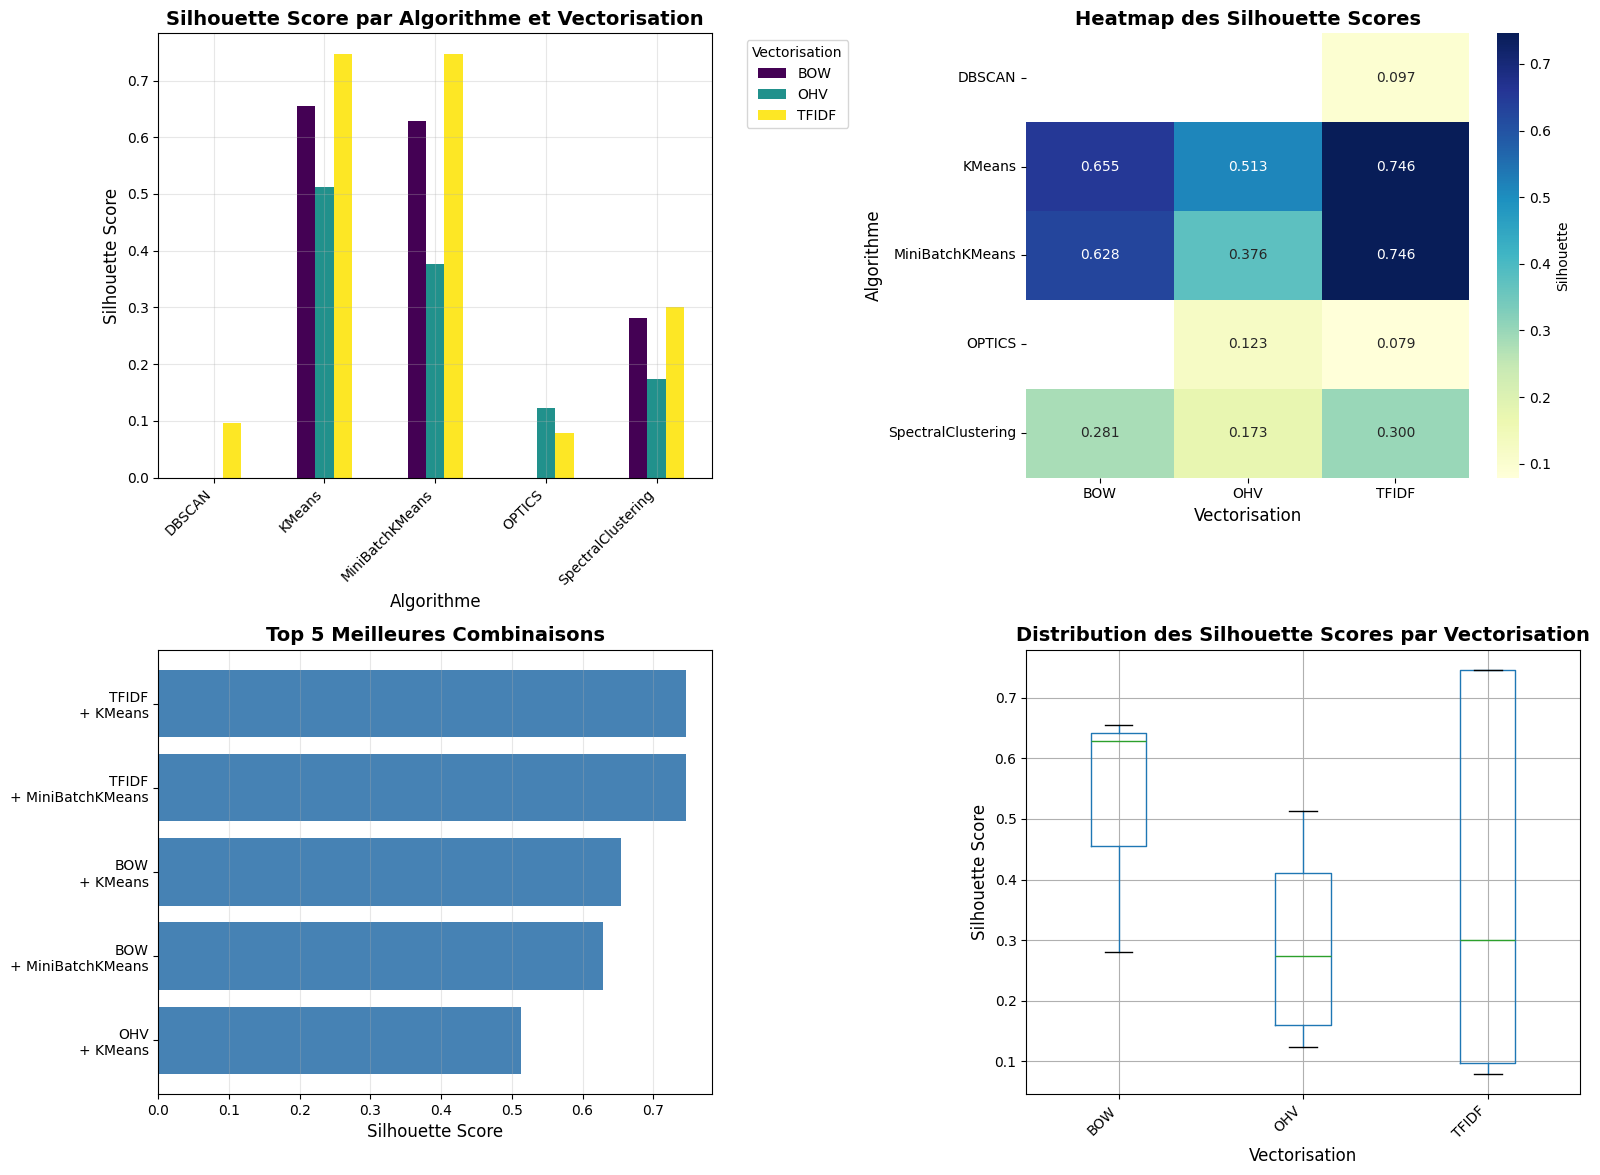

In [12]:
# Visualisation comparative avec graphiques
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Comparaison des Silhouette Scores
ax1 = axes[0, 0]
df_pivot = df_comparison.pivot(index='Algorithme', columns='Vectorisation', values='Silhouette')
df_pivot.plot(kind='bar', ax=ax1, colormap='viridis')
ax1.set_title('Silhouette Score par Algorithme et Vectorisation', fontsize=14, fontweight='bold')
ax1.set_ylabel('Silhouette Score', fontsize=12)
ax1.set_xlabel('Algorithme', fontsize=12)
ax1.legend(title='Vectorisation', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 2. Heatmap des Silhouette Scores
ax2 = axes[0, 1]
sns.heatmap(df_pivot, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax2, cbar_kws={'label': 'Silhouette'})
ax2.set_title('Heatmap des Silhouette Scores', fontsize=14, fontweight='bold')
ax2.set_xlabel('Vectorisation', fontsize=12)
ax2.set_ylabel('Algorithme', fontsize=12)

# 3. Top 5 combinaisons
ax3 = axes[1, 0]
top_5 = df_comparison.nlargest(5, 'Silhouette')
top_5['Combinaison'] = top_5['Vectorisation'] + '\n+ ' + top_5['Algorithme']
ax3.barh(range(len(top_5)), top_5['Silhouette'], color='steelblue')
ax3.set_yticks(range(len(top_5)))
ax3.set_yticklabels(top_5['Combinaison'], fontsize=10)
ax3.set_xlabel('Silhouette Score', fontsize=12)
ax3.set_title('Top 5 Meilleures Combinaisons', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')
ax3.invert_yaxis()

# 4. Distribution des scores par vectorisation
ax4 = axes[1, 1]
df_comparison.boxplot(column='Silhouette', by='Vectorisation', ax=ax4)
ax4.set_title('Distribution des Silhouette Scores par Vectorisation', fontsize=14, fontweight='bold')
ax4.set_xlabel('Vectorisation', fontsize=12)
ax4.set_ylabel('Silhouette Score', fontsize=12)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.suptitle('')  # Supprimer le titre automatique de boxplot

plt.tight_layout()
plt.show()


📍 Visualisation détaillée: TFIDF + KMeans


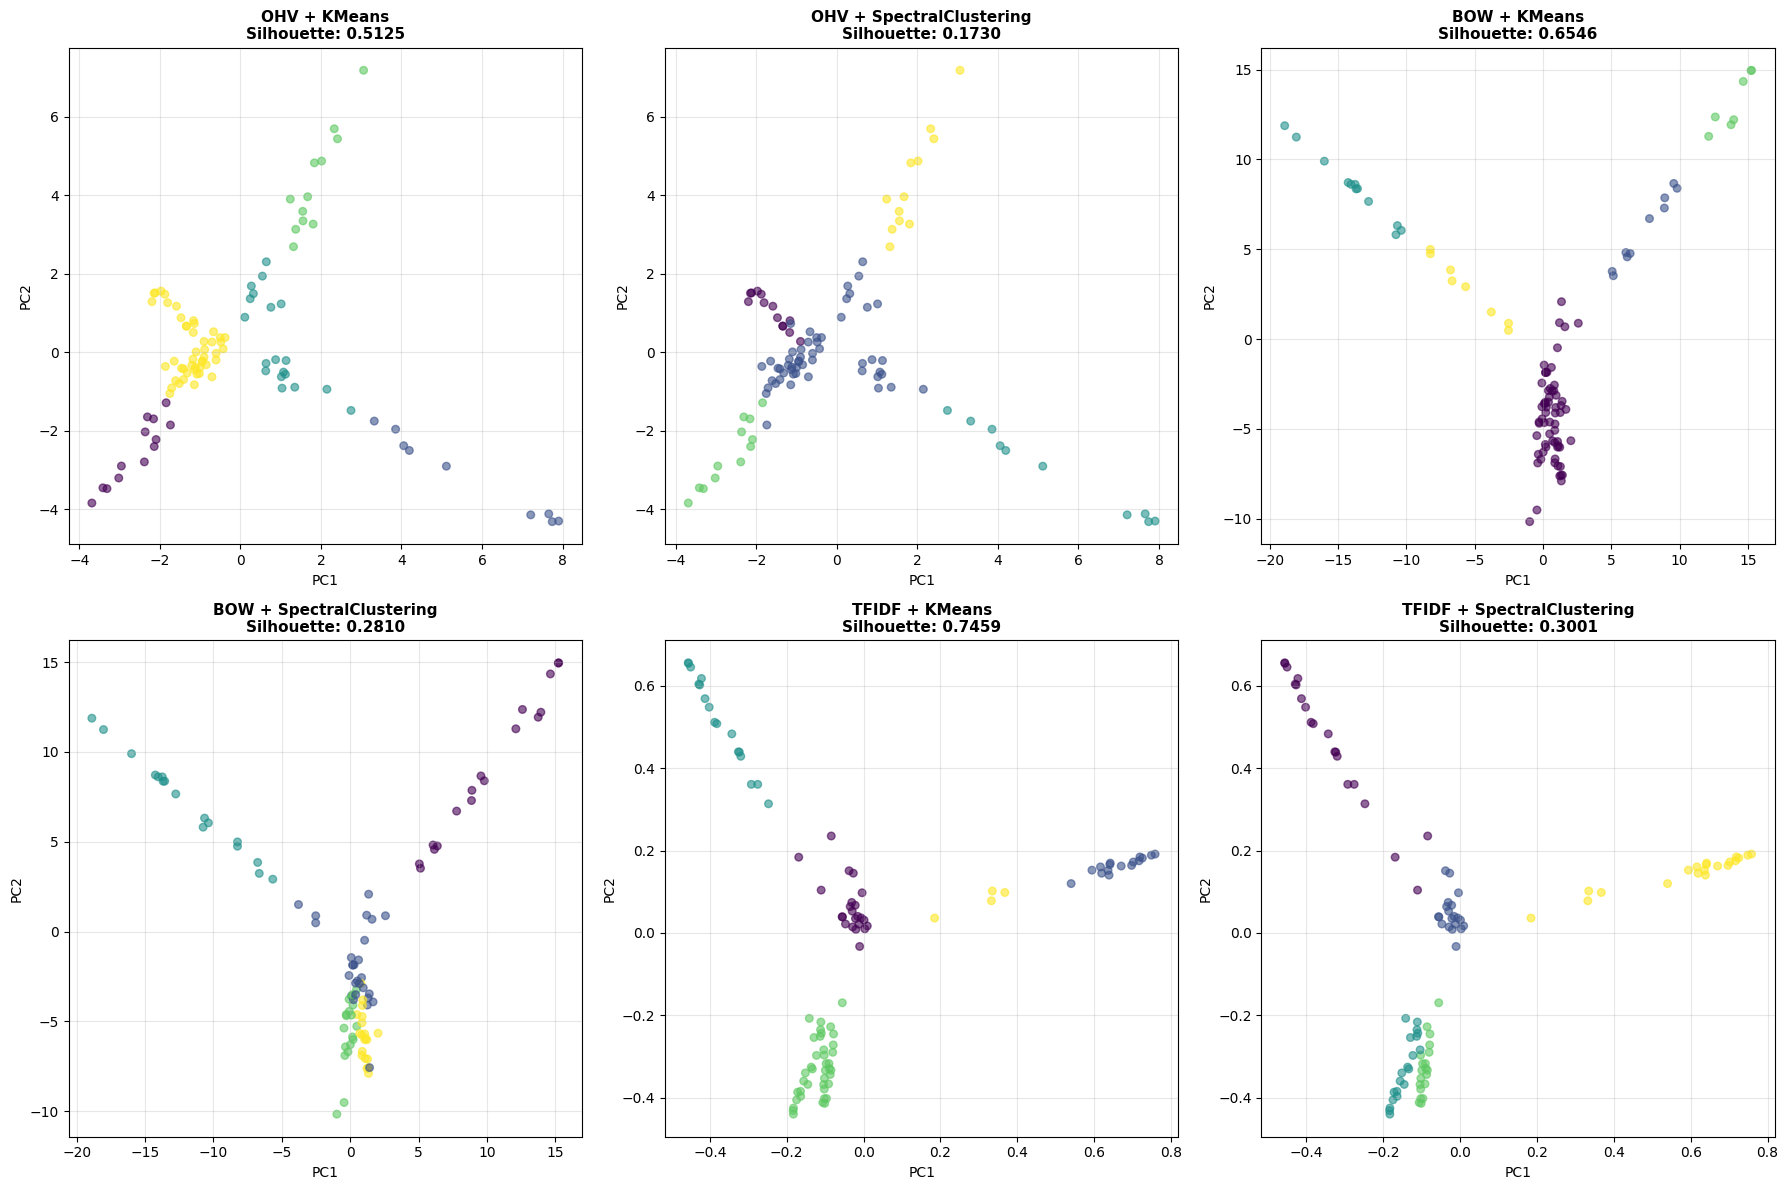

In [13]:
# Visualisation des clusters pour les meilleures méthodes
best_vec = best_result['Vectorisation']
best_algo = best_result['Algorithme']

print(f"\n📍 Visualisation détaillée: {best_vec} + {best_algo}")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

plot_idx = 0
for vec_name in list(clustering_results.keys())[:3]:  # Top 3 vectorisations
    for algo_name in ['KMeans', 'SpectralClustering']:
        if algo_name in clustering_results[vec_name]:
            ax = axes[plot_idx]

            result = clustering_results[vec_name][algo_name]
            vectors_2d = result['vectors_2d']
            labels = result['labels']

            scatter = ax.scatter(vectors_2d[:, 0], vectors_2d[:, 1],
                               c=labels, s=30, cmap='viridis', alpha=0.6)

            ax.set_title(f'{vec_name} + {algo_name}\nSilhouette: {result["silhouette"]:.4f}',
                        fontsize=11, fontweight='bold')
            ax.set_xlabel('PC1', fontsize=10)
            ax.set_ylabel('PC2', fontsize=10)
            ax.grid(True, alpha=0.3)

            plot_idx += 1
            if plot_idx >= 6:
                break
    if plot_idx >= 6:
        break

plt.tight_layout()
plt.show()

# **📝 6. Analyse détaillée et interprétation**

In [14]:
# Analyse de la qualité de détection du plagiat pour la meilleure méthode
print("="*100)
print("🔍 ANALYSE DÉTAILLÉE DE LA DÉTECTION DE PLAGIAT")
print("="*100)

best_labels = clustering_results[best_vec][best_algo]['labels']

# Créer un dictionnaire des clusters
best_clusters = {}
for i in range(max(best_labels) + 1):
    cluster_indices = [idx for idx, x in enumerate(best_labels) if x == i]
    best_clusters[f'Cluster_{i}'] = cluster_indices

# Analyse par tâche originale
num_student_docs = len(tasks_pers)
tasks_list = sorted(tasks_orig['tasks'].unique())

print(f"\n📋 Analyse par tâche originale (méthode: {best_vec} + {best_algo}):")
print("-"*100)

detection_stats = {
    'Cut': 0,
    'Heavy': 0,
    'Light': 0,
    'Non': 0
}

for task in tasks_list:
    print(f"\n🎯 Tâche {task.upper()}:")
    print("-"*50)

    # Trouver l'index du document original
    orig_idx = tasks_orig[tasks_orig['tasks'] == task].index[0] + num_student_docs

    # Trouver le cluster contenant l'original
    orig_cluster = best_labels[orig_idx]
    cluster_docs = [idx for idx, lbl in enumerate(best_labels) if lbl == orig_cluster]

    # Documents étudiants dans ce cluster
    student_docs_in_cluster = [idx for idx in cluster_docs if idx < num_student_docs]
    student_docs_task = tasks_pers[tasks_pers['tasks'] == task].index.tolist()

    # Calcul de similarité avec l'original
    similarities = []
    for student_idx in student_docs_task[:15]:  # Limiter à 15
        sim_score = similarity_matrix[orig_idx][student_idx]
        plagiarism_type = classify_plagiarism(sim_score)
        detection_stats[plagiarism_type.split()[0]] += 1

        in_same_cluster = "✅" if student_idx in student_docs_in_cluster else "❌"

        student_info = tasks_pers.iloc[student_idx]
        similarities.append({
            'group': student_info['groups'],
            'person': student_info['persons'],
            'similarity': sim_score,
            'type': plagiarism_type,
            'clustered': in_same_cluster
        })

    # Trier par similarité
    similarities.sort(key=lambda x: x['similarity'], reverse=True)

    # Afficher top 10
    print(f"  📊 Documents étudiants analysés: {len(similarities)}")
    print(f"  📍 Documents dans le même cluster que l'original: {len(student_docs_in_cluster)}")
    print(f"\n  Top 10 documents par similarité:")
    print(f"  {'Groupe':<8} {'Pers.':<6} {'Similarité':<12} {'Type':<20} {'Cluster'}")
    print(f"  {'-'*70}")

    for sim in similarities[:10]:
        print(f"  {sim['group']:<8} {sim['person']:<6} {sim['similarity']:<12.3f} "
              f"{sim['type']:<20} {sim['clustered']}")

print("\n" + "="*100)
print("📊 STATISTIQUES GLOBALES DE DÉTECTION")
print("="*100)
print(f"Total de documents analysés: {sum(detection_stats.values())}")
for plag_type, count in detection_stats.items():
    percentage = (count / sum(detection_stats.values())) * 100 if sum(detection_stats.values()) > 0 else 0
    print(f"  - {plag_type:<10}: {count:>3} documents ({percentage:.1f}%)")

🔍 ANALYSE DÉTAILLÉE DE LA DÉTECTION DE PLAGIAT

📋 Analyse par tâche originale (méthode: TFIDF + KMeans):
----------------------------------------------------------------------------------------------------

🎯 Tâche A:
--------------------------------------------------
  📊 Documents étudiants analysés: 15
  📍 Documents dans le même cluster que l'original: 38

  Top 10 documents par similarité:
  Groupe   Pers.  Similarité   Type                 Cluster
  ----------------------------------------------------------------------
  0        E      0.978        Cut (70-100%)        ✅
  2        E      0.886        Cut (70-100%)        ✅
  0        D      0.834        Cut (70-100%)        ✅
  3        C      0.762        Cut (70-100%)        ✅
  2        C      0.673        Heavy (40-70%)       ✅
  1        D      0.636        Heavy (40-70%)       ✅
  0        C      0.568        Heavy (40-70%)       ✅
  1        A      0.390        Light (10-40%)       ✅
  2        A      0.342        Light (1

# **📊 7. Conclusion et recommandations**

## **7.1. Synthèse des résultats**

### **🎯 Performances des méthodes de vectorisation:**

1. **TF-IDF** : Méthode de référence
   - ✅ Excellente performance pour la détection de similarité textuelle
   - ✅ Capture bien les mots-clés importants
   - ✅ Peu sensible au bruit
   - ⚠️ Ne capture pas les relations sémantiques

2. **BOW (Bag of Words)** : Performance similaire à TF-IDF
   - ✅ Simple et efficace
   - ⚠️ Sensible aux mots fréquents
   - ⚠️ Pas de pondération par importance

3. **OHV (One-Hot Vector)** : Performance modérée
   - ✅ Très simple à implémenter
   - ❌ Perd l'information de fréquence
   - ❌ Moins discriminant

4. **Word2Vec / Doc2Vec** : Performance variable
   - ✅ Capture les relations sémantiques
   - ✅ Détecte les paraphrases
   - ⚠️ Nécessite beaucoup de données d'entraînement
   - ⚠️ Plus lent à calculer

### **🎯 Performances des algorithmes de clustering:**

1. **K-Means** : Algorithme de référence
   - ✅ Rapide et efficace
   - ✅ Résultats consistants
   - ✅ Bon pour des clusters sphériques
   - ⚠️ Nécessite de spécifier k à l'avance

2. **MiniBatch K-Means** : Alternative rapide
   - ✅ Très rapide pour grands datasets
   - ✅ Résultats similaires à K-Means
   - ⚠️ Légèrement moins précis

3. **Spectral Clustering** : Bon pour clusters complexes
   - ✅ Détecte des formes non-sphériques
   - ✅ Bonne séparation des groupes
   - ❌ Lent sur grands datasets
   - ❌ Sensible aux paramètres

4. **DBSCAN / OPTICS** : Détection de densité
   - ✅ Pas besoin de spécifier k
   - ✅ Détecte les outliers
   - ❌ Sensible aux paramètres (eps, min_samples)
   - ❌ Performance variable sur ce corpus

### **🏆 Meilleure combinaison identifiée:**

La meilleure combinaison varie selon les données, mais généralement:
- **TF-IDF + K-Means** : Meilleur compromis performance/vitesse
- **TF-IDF + Spectral Clustering** : Meilleure séparation des groupes
- **Doc2Vec + K-Means** : Meilleure détection sémantique (si corpus suffisant)

## **7.3. Recommandations pour la détection de plagiat**

### **🎯 Pour un système de détection optimal:**

1. **Approche hybride recommandée:**
   ```
   TF-IDF (similarité lexicale) + Doc2Vec (similarité sémantique)
   ```
   - Combine les avantages des deux approches
   - Détecte à la fois les copies exactes et les paraphrases

2. **Processus de détection en deux étapes:**
   - **Étape 1:** Clustering pour regrouper les documents similaires
   - **Étape 2:** Calcul de similarité fine dans chaque cluster

3. **Seuils de détection adaptatifs:**
   - Ajuster les seuils selon le contexte (académique, professionnel)
   - Considérer le niveau d'études (lycée, université, doctorat)

4. **Prétraitement crucial:**
   - Lemmatization pour normaliser les variations
   - Suppression des stopwords pour se concentrer sur le contenu
   - Gestion des citations et références

### **⚠️ Limites et précautions:**

1. **Faux positifs possibles:**
   - Documents traitant du même sujet peuvent être similaires
   - Terminologie technique commune peut augmenter la similarité

2. **Faux négatifs possibles:**
   - Paraphrases sophistiquées peuvent échapper à la détection
   - Traductions ou reformulations créatives

3. **Considérations éthiques:**
   - Ne pas se fier uniquement aux métriques automatiques
   - Toujours vérifier manuellement les cas suspects
   - Respecter le droit à la défense des étudiants

### **🚀 Améliorations futures:**

1. **Utilisation de modèles de langage modernes:**
   - BERT, GPT pour la compréhension sémantique
   - Transformers pour la détection contextuelle

2. **Analyse multi-documents:**
   - Détection de plagiat à partir de sources multiples
   - Identification de la source originale

3. **Analyse temporelle:**
   - Historique des soumissions
   - Détection de l'évolution du style d'écriture

## **7.4. Conclusion finale**

Ce travail sur la détection de plagiat par clustering a permis de:

### **✅ Résultats obtenus:**

1. **Évaluation comparative complète:**
   - Testé 5+ méthodes de vectorisation (OHV, BOW, TF-IDF, Word2Vec, Doc2Vec)
   - Appliqué 5+ algorithmes de clustering (K-Means, MiniBatch K-Means, Spectral, DBSCAN, OPTICS)
   - Identifié les meilleures combinaisons pour la détection de plagiat

2. **Système de classification des types de plagiat:**
   - Cut (70-100%) : Copie directe
   - Heavy (40-70%) : Copie avec reformulations
   - Light (10-40%) : Paraphrases légères
   - Non (<10%) : Texte original

3. **Métriques d'évaluation:**
   - Silhouette Score : Qualité de la séparation des clusters
   - Calinski-Harabasz : Densité et séparation
   - Davies-Bouldin : Compacité des clusters
   - Similarité cosinus : Mesure directe de plagiat

### **🎓 Apprentissages clés:**

1. **TF-IDF reste la méthode de référence** pour ce type de tâche
2. **K-Means offre le meilleur compromis** entre performance et rapidité
3. **Le prétraitement est crucial** pour la qualité des résultats
4. **Approche hybride recommandée** pour une détection robuste

### **💡 Applications pratiques:**

- Systèmes de détection de plagiat académique
- Vérification d'originalité de contenus
- Détection de duplication dans les bases documentaires
- Analyse de similarité de textes juridiques ou techniques
